In [124]:
# Imports and data loading

import pandas as pd
import matplotlib.pyplot as plt

# Load trading data
trades = pd.read_csv(
    "C:\\Users\\blazo\\Documents\\Misc\\QJ\\quant-journey\\research\\ftmo\\data\\Z6+_trd.csv"
)

trades = trades.sort_values('Close')
trades['equity'] = trades['Profit'].cumsum()

In [125]:
# Summary of overall performance

print("\n" + "=" * 80)
print("COMPARATIVE SUMMARY")
print("=" * 80)
print(f"Z6+ Performance: ${trades['Profit'].sum():.2f} ({len(trades)} trades)")

# Calculate win/loss statistics for each strategy
z6p_wins = trades[trades['Profit'] > 0]['Profit']
z6p_losses = trades[trades['Profit'] <= 0]['Profit']

print(f"\nZ6+ Statistics:")
trades['Close'] = pd.to_datetime(trades['Close'])
print(f"  Average Trades per Day: {len(trades) / trades['Close'].dt.date.nunique():.2f}")
print(f"  Average Win: ${z6p_wins.mean():.2f} ({len(z6p_wins)} winning trades)")
print(f"  Average Loss: ${z6p_losses.mean():.2f} ({len(z6p_losses)} losing trades)")
print(f"  Win/Loss Ratio: {(len(z6p_wins) / (len(z6p_losses))):.2f}")
print(f"  Win Percentage: {(len(z6p_wins) / (len(z6p_wins) + len(z6p_losses))) * 100:.2f} %")


COMPARATIVE SUMMARY
Z6+ Performance: $80221.06 (3237 trades)

Z6+ Statistics:
  Average Trades per Day: 2.36
  Average Win: $130.18 (2054 winning trades)
  Average Loss: $-158.22 (1183 losing trades)
  Win/Loss Ratio: 1.74
  Win Percentage: 63.45 %


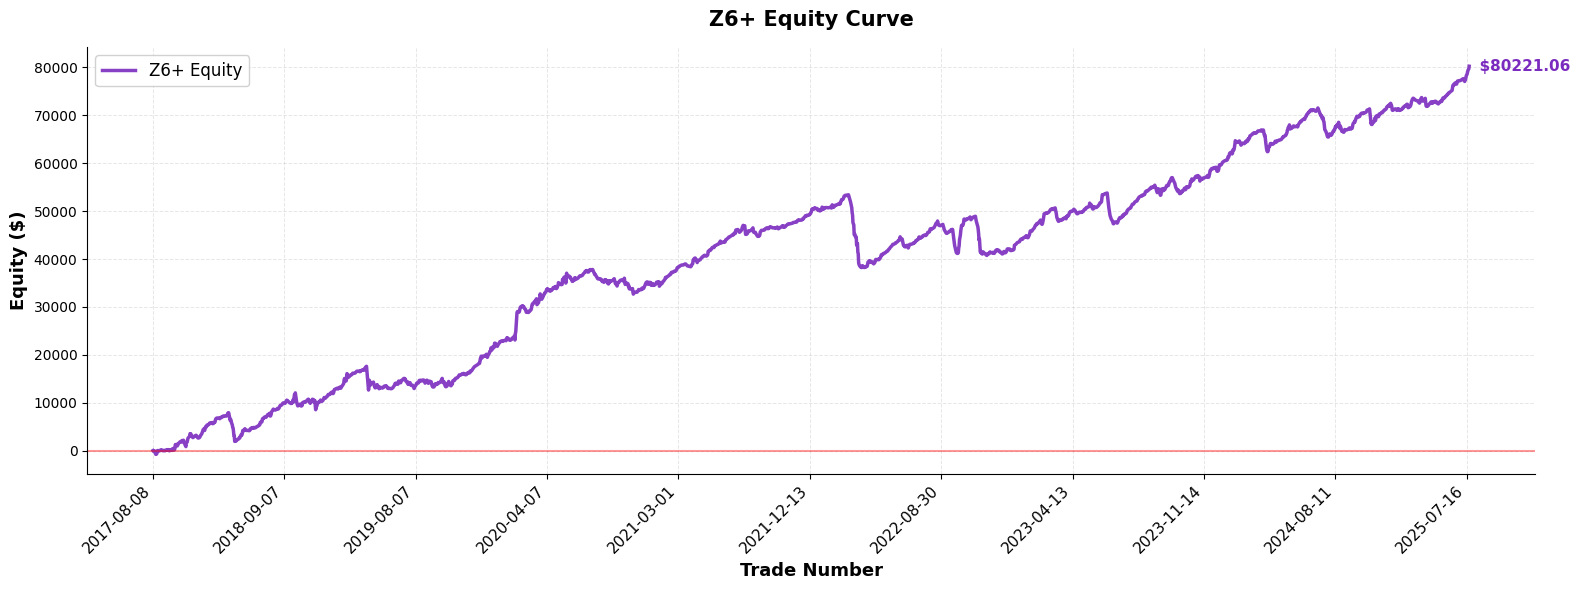

In [126]:
# Create equity curve plot
fig, ax = plt.subplots(figsize=(16, 6))

# Create positions for x-axis (just use sequential indices)
positions = range(len(trades))

# Plot equity curve
ax.plot(positions, trades['equity'].values, linewidth=2.5, 
    color='#7B2CBF', label='Z6+ Equity', alpha=0.9)

# Add final value annotation
final_value = trades['equity'].iloc[-1]
final_pos = len(trades) - 1
ax.text(final_pos, final_value, f'  ${final_value:.2f}', 
    va='center', ha='left', fontsize=11, fontweight='bold', color='#7B2CBF')

ax.set_xlabel('Trade Number', fontsize=13, fontweight='bold')
ax.set_ylabel('Equity ($)', fontsize=13, fontweight='bold')
ax.set_title('Z6+ Equity Curve', fontsize=15, fontweight='bold', pad=15)
ax.legend(fontsize=12, loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
ax.axhline(y=0, color='red', linestyle='-', linewidth=1.5, alpha=0.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set x-axis ticks with dates at regular intervals
tick_interval = max(1, len(trades) // 10)
tick_positions = list(range(0, len(trades), tick_interval))
ax.set_xticks(tick_positions)
ax.set_xticklabels([trades['Close'].iloc[i].strftime('%Y-%m-%d') for i in tick_positions], 
            rotation=45, ha='right', fontsize=11)

plt.tight_layout()
plt.show()

In [127]:
# Calculate daily profit/loss
trades['Date'] = trades['Close'].dt.date
daily_pnl = trades.groupby('Date')['Profit'].sum()

# Maximum loss in a single day
max_daily_loss = daily_pnl.min()

# Calculate drawdown
cumulative_pnl = daily_pnl.cumsum()
running_max = cumulative_pnl.cummax()
drawdown = cumulative_pnl - running_max
max_drawdown = drawdown.min()

print("\n" + "=" * 80)
print("RISK METRICS")
print("=" * 80)
print(f"Maximum Daily Loss: ${max_daily_loss:.2f}")
print(f"Maximum Drawdown: ${max_drawdown:.2f}")
print(f"Date of Max Daily Loss: {daily_pnl.idxmin()}")
print(f"Date of Max Drawdown: {drawdown.idxmin()}")


RISK METRICS
Maximum Daily Loss: $-6083.82
Maximum Drawdown: $-15075.49
Date of Max Daily Loss: 2022-03-08
Date of Max Drawdown: 2022-03-10


In [128]:
df = trades[['Type', 'Asset', 'Open', 'Close', 'Entry', 'Exit', 'Lots']]

df = df.copy()
df['Pip Profit'] = (df['Exit'] - df['Entry']) * df['Type'].apply(lambda x: 1 if x == 'Long' else -1)

df['Trade Length'] = (pd.to_datetime(df['Close']) - pd.to_datetime(df['Open'])).dt.total_seconds() / 86400
df['Trade Length'] = df['Trade Length'].clip(upper=7)

df.head()

,Type,Asset,Open,Close,Entry,Exit,Lots,Pip Profit,Trade Length
0,Long,GBP/AUD,2017-08-08 12:32,2017-08-08 23:50:00,1.640120,1.644079,16,0.003959,0.470833
1,Short,AUD/USD,2017-08-08 14:10,2017-08-09 06:24:00,1.224490,1.234610,16,-0.010120,0.676389
2,Short,GBP/NZD,2017-08-10 05:15,2017-08-10 18:52:00,1.778768,1.780890,16,-0.002122,0.567361
3,Short,GBP/AUD,2017-08-11 01:45,2017-08-11 07:33:00,1.654325,1.651090,16,0.003235,0.241667
4,Short,GBP/NZD,2017-08-10 07:49,2017-08-11 12:53:00,1.785100,1.776510,16,0.008590,1.211111


Average Pip Profit by Trade Length:
Trade Length Bin
[0, 1)    0.006686
[1, 2)    0.005849
[2, 3)    0.002416
[3, 4)    0.004209
[4, 5)    0.003611
[5, 6)    0.003581
[6, 7)   -0.000658
Name: Pip Profit, dtype: float64


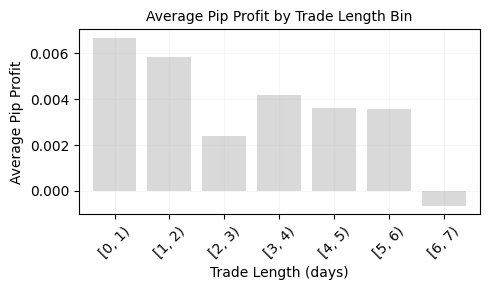

In [129]:
# Calculate average pip profit for each trade length bin
bins_edges = [0, 1, 2, 3, 4, 5, 6, 7]
df['Trade Length Bin'] = pd.cut(df['Trade Length'], bins=bins_edges, right=False)
avg_pip_profit_by_length = df.groupby('Trade Length Bin', observed=False)['Pip Profit'].mean()

print("Average Pip Profit by Trade Length:")
print(avg_pip_profit_by_length)

# Visualize the results
plt.figure(figsize=(5, 3))
avg_pip_profit_by_length.plot(kind='bar', color="#CACACA", alpha=0.7, width=0.8)
plt.xlabel('Trade Length (days)', fontsize=10, fontweight='normal')
plt.ylabel('Average Pip Profit', fontsize=10, fontweight='normal')
plt.title('Average Pip Profit by Trade Length Bin', fontsize=10, fontweight='normal')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.1, linestyle='-')
plt.tight_layout()
plt.show()

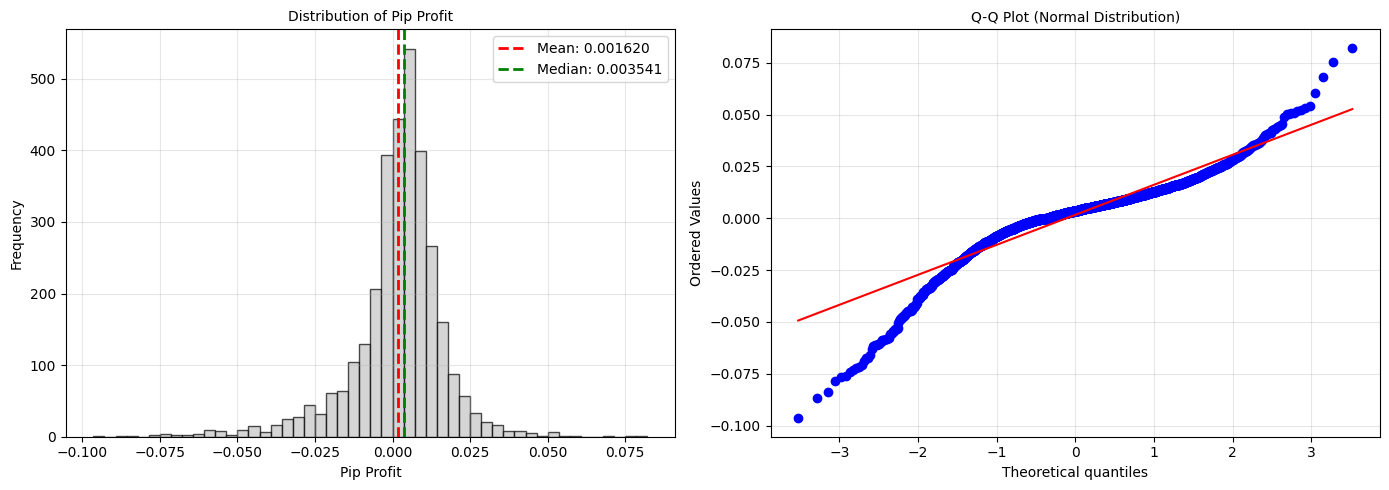


PIP PROFIT DISTRIBUTION ANALYSIS
Mean: 0.001620
Median: 0.003541
Std Dev: 0.015295
Skewness: -1.2048
Kurtosis: 5.3419

Kurtosis > 3 indicates fat tails (leptokurtic distribution)
Kurtosis < 3 indicates thin tails (platykurtic distribution)
Normal distribution has kurtosis = 0 (excess kurtosis)

Percentile Analysis:
1st percentile: -0.054814
5th percentile: -0.026455
95th percentile: 0.021343
99th percentile: 0.035938


In [130]:
from scipy import stats

# Analyze the distribution of Pip Profit for fat tails
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with KDE
axes[0].hist(df['Pip Profit'], bins=50, color="#C4C4C4", alpha=0.7, edgecolor='black')
axes[0].axvline(df['Pip Profit'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["Pip Profit"].mean():.6f}')
axes[0].axvline(df['Pip Profit'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["Pip Profit"].median():.6f}')
axes[0].set_xlabel('Pip Profit', fontsize=10, fontweight='normal')
axes[0].set_ylabel('Frequency', fontsize=10, fontweight='normal')
axes[0].set_title('Distribution of Pip Profit', fontsize=10, fontweight='normal')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Q-Q plot to check for fat tails
stats.probplot(df['Pip Profit'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Normal Distribution)', fontsize=10, fontweight='normal')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate key statistics
print("\n" + "=" * 80)
print("PIP PROFIT DISTRIBUTION ANALYSIS")
print("=" * 80)
print(f"Mean: {df['Pip Profit'].mean():.6f}")
print(f"Median: {df['Pip Profit'].median():.6f}")
print(f"Std Dev: {df['Pip Profit'].std():.6f}")
print(f"Skewness: {df['Pip Profit'].skew():.4f}")
print(f"Kurtosis: {df['Pip Profit'].kurtosis():.4f}")
print(f"\nKurtosis > 3 indicates fat tails (leptokurtic distribution)")
print(f"Kurtosis < 3 indicates thin tails (platykurtic distribution)")
print(f"Normal distribution has kurtosis = 0 (excess kurtosis)")

# Percentile analysis
print(f"\nPercentile Analysis:")
print(f"1st percentile: {df['Pip Profit'].quantile(0.01):.6f}")
print(f"5th percentile: {df['Pip Profit'].quantile(0.05):.6f}")
print(f"95th percentile: {df['Pip Profit'].quantile(0.95):.6f}")
print(f"99th percentile: {df['Pip Profit'].quantile(0.99):.6f}")